# softmax回归的从零开始实现

就像我们从零开始实现线性回归一样，
你应该知道实现softmax的细节
softmax回归

In [1]:
import sys
sys.path.append('..')

In [2]:
import mindspore
import numpy as np
from IPython import display
from d2l import mindspore as d2l

batch_size = 256
mnist_train, mnist_test = d2l.load_data_fashion_mnist('../data', batch_size)

将展平每个图像，把它们看作长度为784的向量。
因为我们的数据集有10个类别，所以网络输出维度为10

In [3]:
num_inputs = 784
num_outputs = 10

给定一个矩阵`X`，我们可以对所有元素求和

In [4]:
X = mindspore.Tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], mindspore.float32)
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(Tensor(shape=[1, 3], dtype=Float32, value=
 [[ 5.00000000e+00,  7.00000000e+00,  9.00000000e+00]]),
 Tensor(shape=[2, 1], dtype=Float32, value=
 [[ 6.00000000e+00],
  [ 1.50000000e+01]]))

实现softmax

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$

In [5]:
import mindspore.ops as ops

def softmax(X):
    X_exp = ops.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition

我们将每个元素变成一个非负数。此外，依据概率原理，每行总和为1

In [6]:
X = mindspore.Tensor(np.random.normal(0, 1, (2, 5)), mindspore.float32)
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(Tensor(shape=[2, 5], dtype=Float32, value=
 [[ 3.54202002e-01,  8.97009075e-02,  2.78266482e-02,  3.57240200e-01,  1.71030268e-01],
  [ 2.62537301e-01,  3.89088303e-01,  4.16863486e-02,  2.20235527e-01,  8.64524469e-02]]),
 Tensor(shape=[2], dtype=Float32, value= [ 1.00000000e+00,  1.00000000e+00]))

实现softmax回归模型

In [7]:
import mindspore.nn as nn
from mindspore import Tensor, Parameter
from mindspore.common.initializer import initializer, Zero, Normal

class Net(nn.Cell):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.W = Parameter(initializer(Normal(0.01, 0), (num_inputs, num_outputs), mindspore.float32))
        self.b = Parameter(initializer(Zero(), num_outputs, mindspore.float32))

    def construct(self, X):
        return softmax(ops.matmul(X.reshape((-1, self.W.shape[0])), self.W) + self.b)

创建一个数据样本`y_hat`，其中包含2个样本在3个类别的预测概率，及它们对应的标签`y`。
使用`y`作为`y_hat`中概率的索引

In [8]:
y = mindspore.Tensor([0, 2], mindspore.int32)
y_hat = mindspore.Tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]], mindspore.float32)
y_hat[[0, 1], y]

Tensor(shape=[2], dtype=Float32, value= [ 1.00000001e-01,  5.00000000e-01])

实现交叉熵损失函数

In [9]:
import mindspore.numpy as mnp

def cross_entropy(y_hat, y):
    return -mnp.log(y_hat[mnp.arange(y_hat.shape[0]), y])

cross_entropy(y_hat, y)

Tensor(shape=[2], dtype=Float32, value= [ 2.30258512e+00,  6.93147182e-01])

将预测类别与真实`y`元素进行比较

In [10]:
def accuracy(y_hat, y):  
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.asnumpy() == y.asnumpy()
    return float(cmp.sum())

accuracy(y_hat, y) / len(y)

0.5

我们可以评估在任意模型`net`的精度

In [11]:
def evaluate_accuracy(net, data_iter):  
    """计算在指定数据集上模型的精度。"""
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X.astype(mindspore.int8)), y.astype(mindspore.int32)), y.size)
    return metric[0] / metric[1]

`Accumulator`实例中创建了2个变量，用于分别存储正确预测的数量和预测的总数量

In [12]:
class Accumulator:  
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

net = Net(num_inputs, num_outputs)
evaluate_accuracy(net, mnist_test.create_tuple_iterator())

0.1071

Softmax回归的训练

In [13]:
def train_epoch_ch3(net, train_iter, loss, optim):  
    """训练模型一个迭代周期（定义见第3章）。"""
    net_with_loss = d2l.NetWithLoss(net, loss)
    net_train = d2l.Train(net_with_loss, optim)
    metric = Accumulator(3)
    for X, y in train_iter:
        l = net_train(X.astype(mindspore.int8), y.astype(mindspore.int32))
        y_hat = net(X.astype(mindspore.int8))
        metric.add(float(l.sum().asnumpy()), accuracy(y_hat, y), y.size)
    return metric[0] / metric[2], metric[1] / metric[2]

定义一个在动画中绘制数据的实用程序类

In [14]:
class Animator:  
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

训练函数

In [15]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optim):  
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optim)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.6, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

小批量随机梯度下降来优化模型的损失函数

In [16]:
lr = 0.1

optim = d2l.SGD(lr, batch_size, net.trainable_params())

训练模型10个迭代周期

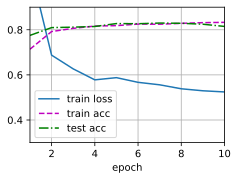

In [17]:
num_epochs = 10
train_iter = mnist_train.create_tuple_iterator()
test_iter = mnist_test.create_tuple_iterator()
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, optim)

对图像进行分类预测

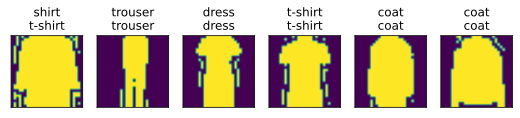

In [18]:
def predict_ch3(net, test_iter, n=6):  
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y.asnumpy())
    preds = d2l.get_fashion_mnist_labels(net(X.astype(mindspore.int8)).argmax(axis=1).asnumpy())
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)